In [1]:
from astropy.io import fits
import numpy as np
import astropy
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats 
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages

In [369]:
file_path = '/home/arya/Desktop/Det_gain_offset_merged_data/Det_H/europium.fits'
hdulist = fits.open(file_path)

In [371]:
data = hdulist[1].data
print(Table(data))

   time    detid pixid pha 
---------- ----- ----- ----
3560729653     1     9  664
3560729746     1   132  751
3560729829     0   168 1431
3560729873     1    35 1035
3560729950     0   228 1333
3560729974     1    62 1631
3560729999     0   150 1935
3560730185     1   201 1288
3560730348     0   225 1633
3560730374     1   122 1542
       ...   ...   ...  ...
2974629195     1   138  743
2974629246     1   197 1557
2974629295     1    86 1616
2974629378     1    79 1783
2974629815     1   153 1799
2974629938     1   124 1511
2974630119     1   195 1306
2974630170     1   150 1238
2974630515     1   211 1041
2974630614     1    77 1480
Length = 7685120 rows


In [373]:
# Filter data for detid == 
detid = data[data['detid'] == int(input("Detector Id (0/1) = "))]

Detector Id (0/1) =  0


In [375]:
# data = detid['pha']
# plt.hist(data,64)

In [431]:
###################################################### Det 0 ###################################
source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
if source == "Am":
    pha_min = 816  # Minimum PHA value
    pha_max = 1200 # Maximum PHA value
    Energy_value = 59.6
elif source == "Ba1":
    pha_min = 304 
    pha_max = 608
    Energy_value = 30.85
elif source == "Ba2":
    pha_min = 1120
    pha_max = 1600+32
    Energy_value = 81
elif source == "Eu2":
    pha_min = 1600-48
    pha_max = 2000-64
    Energy_value = 105.31
else: 
    pha_min = 1296-64
    pha_max =1504+48
    Energy_value = 85.55
print(pha_min,pha_max,Energy_value)

source name (Am/Ba1/Ba2/Eu1/Eu2) =  Eu2


1552 1936 105.31


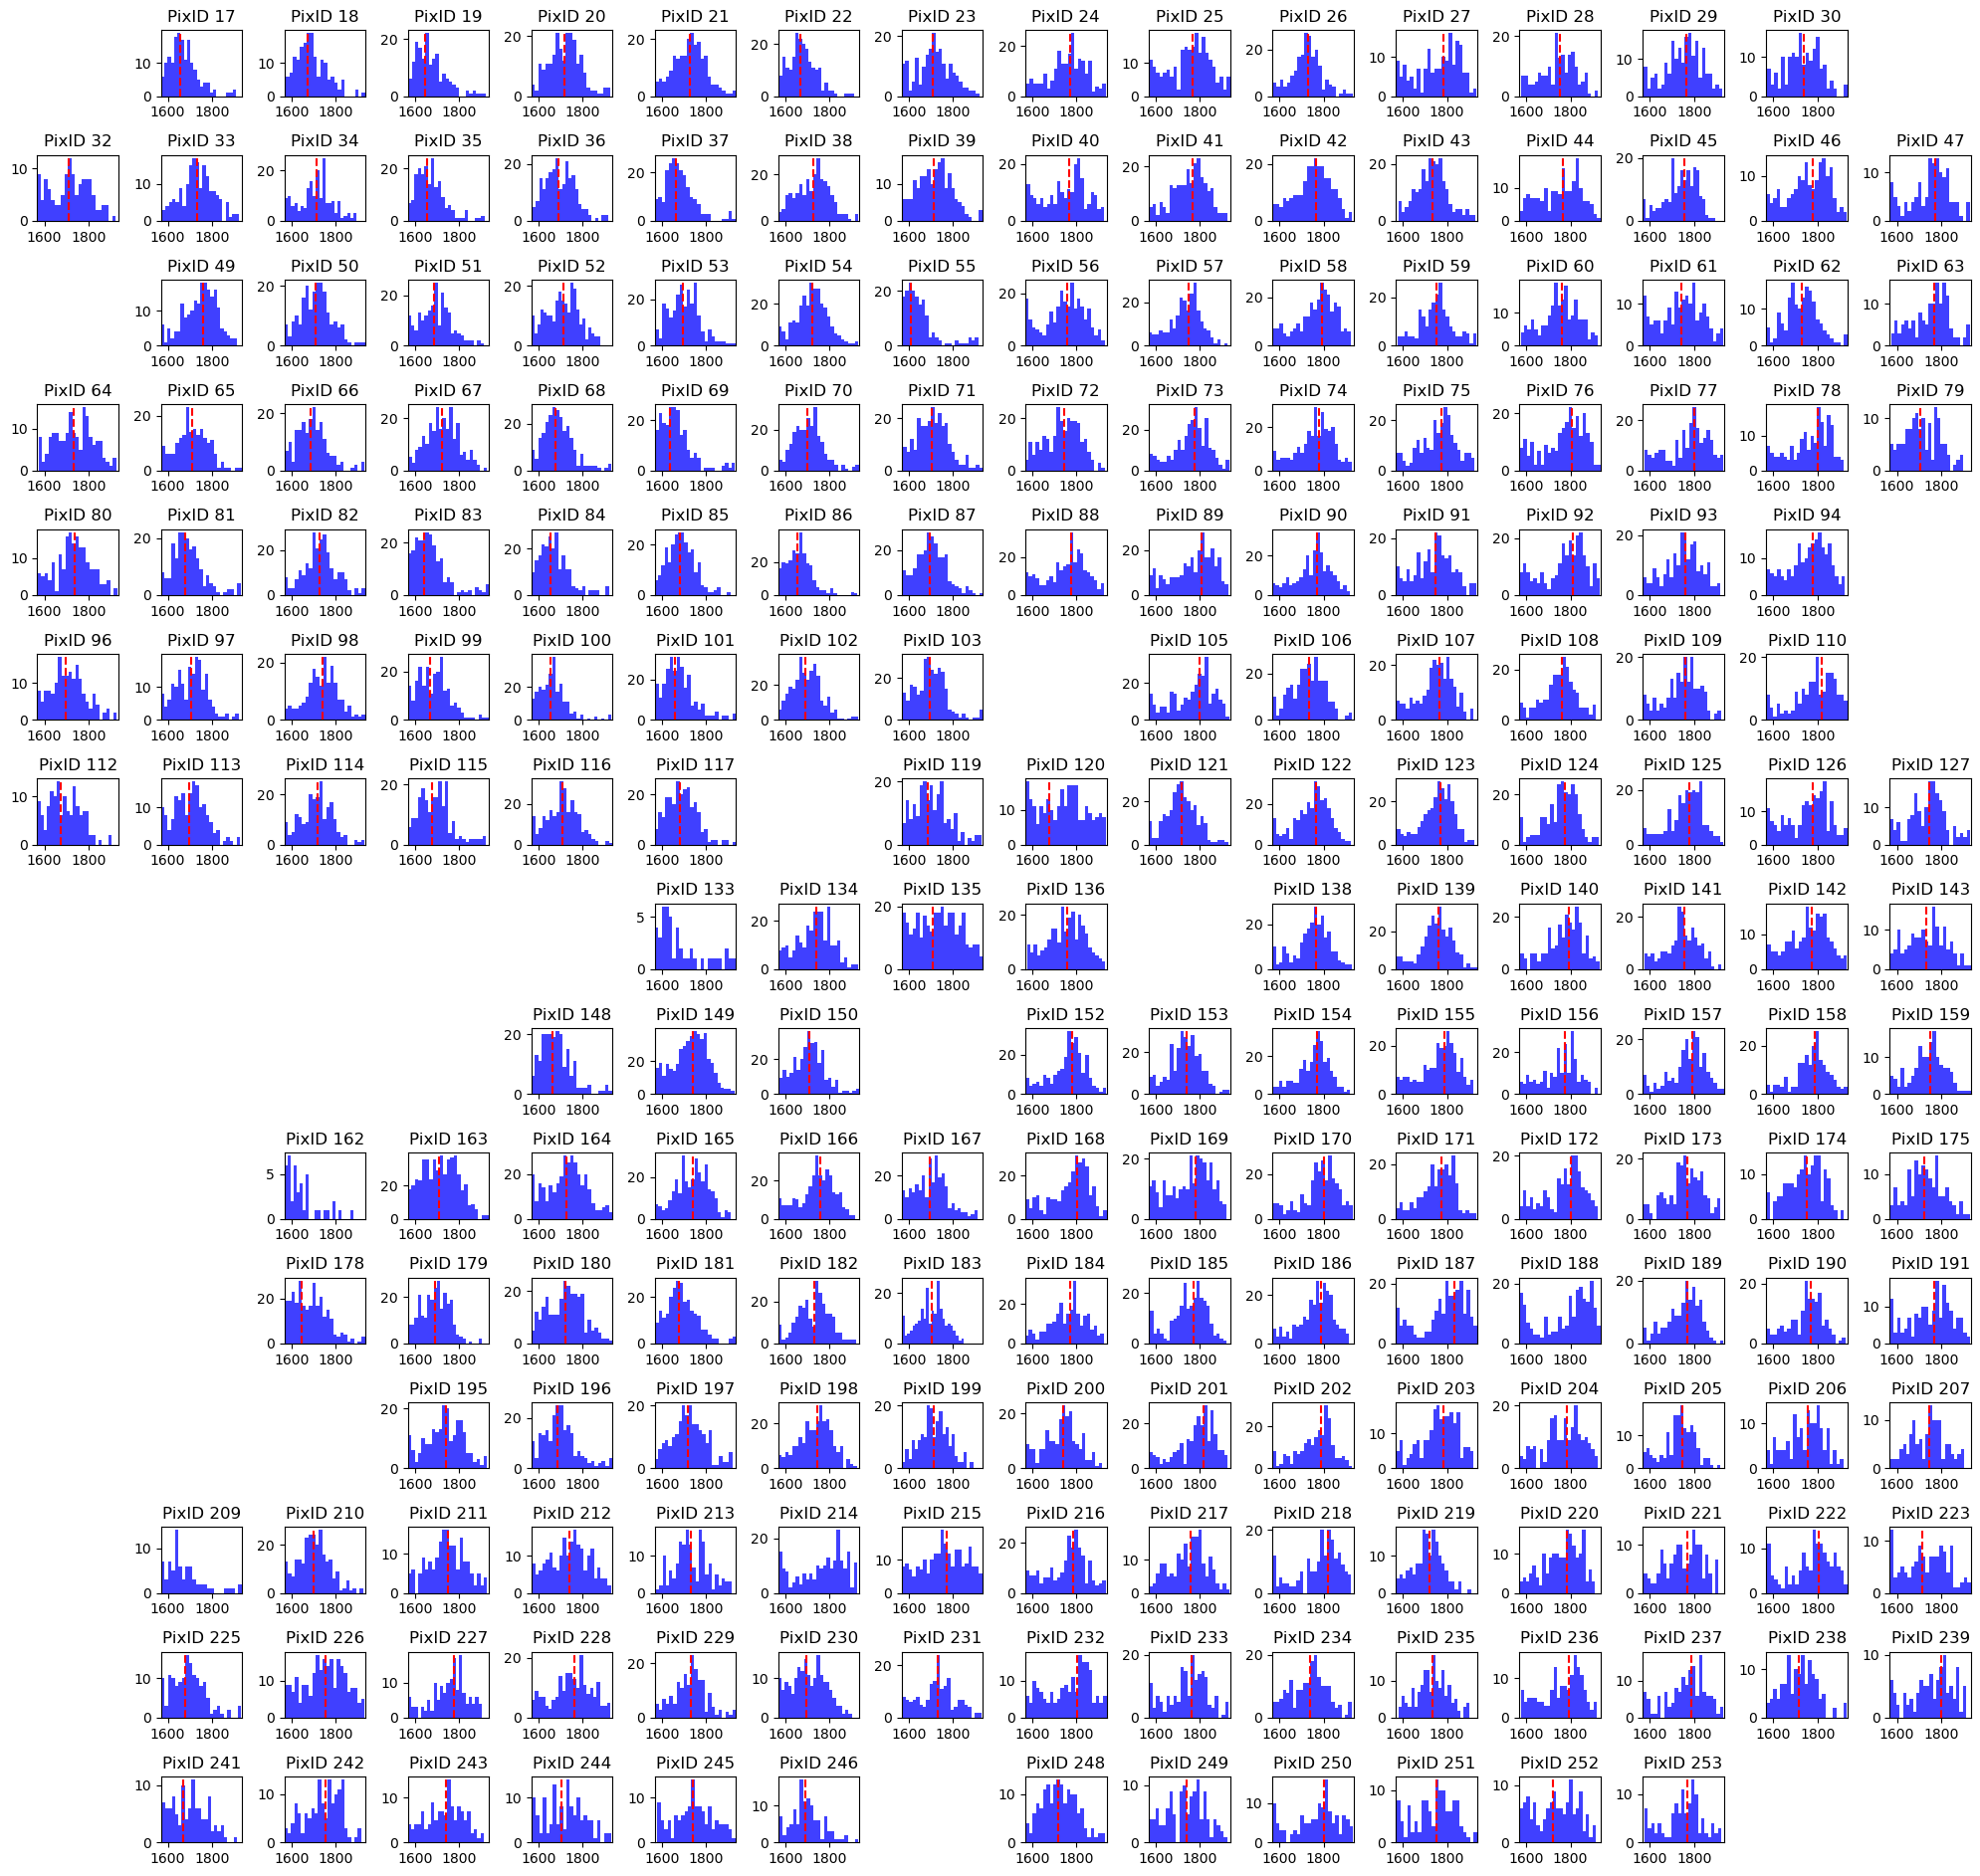

In [429]:
def gauss(x, amp, mean, stdev):
    return amp * np.exp(-(x - mean) ** 2 / (2 * stdev ** 2))

bin_count = int((pha_max - pha_min)/16)

max_count_pha_list = []
max_count_pha_list_OFF = []

for pixid in range(256):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 100:
        N, bins = np.histogram(filtered_data, bins=bin_count)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        p0 = [np.max(N), np.mean(filtered_data), np.std(filtered_data)]
        params = None
        pcov = None
        
        for i in range(10):
            try:
                params, pcov = curve_fit(gauss, bin_centers, N, p0, maxfev=200)
                if np.all((np.abs(p0 - params) / np.sqrt(np.diag(pcov))) > 1):
                    break
                p0 = params
            except RuntimeError:
                continue

        if params is not None:
            max_count_pha_list.append((pixid, params[1], np.sqrt(np.diag(pcov))[1], Energy_value))
        else:
            max_count_pha_list_OFF.append((pixid, None, Energy_value))
    else:
        max_count_pha_list_OFF.append((pixid, None, Energy_value))

# Create 16x16 histogram plot
fig, axes = plt.subplots(16, 16, figsize=(20, 20))
axes = axes.flatten()

for ax, pixid in zip(axes, range(256)):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 10:
        N, bins, _ = ax.hist(filtered_data, bins=bin_count, alpha=0.75, color='blue')
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Check if there's a successful fit
        fit_result = next((item for item in max_count_pha_list if item[0] == pixid), None)
        if fit_result:
            mean_val = fit_result[1]
            ax.axvline(mean_val, color='red', linestyle='--')
        
        ax.set_title(f'PixID {pixid}')
        ax.set_xlim([pha_min, pha_max])
    else:
        ax.set_visible(False)

plt.tight_layout()
#plt.savefig(f'/home/arya/Desktop/Det_gain_offset_merged_data/det{detid}/final_fitting_D{detid}.png')
plt.show()

In [331]:
###################################################  DET 1 limit range #############################################
source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
if source == "Am":
    pha_min = 816  # Minimum PHA value
    pha_max = 1200 # Maximum PHA value
    Energy_value = 59.6
elif source == "Ba1":
    pha_min = 304 
    pha_max = 608
    Energy_value = 30.85
elif source == "Ba2":
    pha_min = 1200-64
    pha_max = 1600-32-16-16
    Energy_value = 81
elif source == "Eu2":
    pha_min = 1632+32+16 
    pha_max = 2000+16
    Energy_value = 105.31
else: 
    pha_min = 1296-64+32+32+8
    pha_max =1664-16-8
    Energy_value = 85.55
print(pha_min,pha_max,Energy_value)

source name (Am/Ba1/Ba2/Eu1/Eu2) =  Ba2


1136 1536 81
